In [1]:
import json
import math
import unidecode
import pandas as pd
import numpy as np
from datetime import datetime
from datetime import date
import matplotlib.pyplot as plt
import folium

In [2]:
ZIP_CODES_PATH = 'zipcodes.json'
CHICAGO_PATH = 'food-inspections.csv'

# Data Cleaning

In [3]:
def split_violation(data):
    """An helper function that calculates the number of violations for each inspection
    Args:
        data(dataframe): the inpsection dataset
    Returns:
        data(dataframe): the inpsection dataset with a new column being the number of violations 
        for each inspection
    """
    lss = list()
    for x in data.Violations:
        sets = set()
        if type(x) == str:
            y = x.split("| ")
            for z in y:
                sets.add(z.split(". ")[0])
        lss.append(sets)
        
    data["violation_number"] = pd.Series( (v for v in lss) )
    
    return data

**Deleted columns**

Here we removed the following columns: 
1. 'Community Areas','Historical Wards 2003-2015',,'Wards','Zip Codes', 'Census Tracts': These columns only contain NaN values.
2. 'Location': This is duplicate with 'longitude' and 'latitude'.
3. 'City','State': These are the same for every single record (Chicago and IL). 

In [4]:
def read_clean_chicago(path):
    """An helper function that preprocess and cleans the input dataset 
    Args:
        path(str): the file path of the chicago food inspection dataset
    Returns:
        dataset(dataframe): the cleaned chicago food inspection dataset
    """
    # Remove unnecessary columns
    features = ['Inspection ID', 'DBA Name', 'AKA Name', 'License #', 'Facility Type', \
            'Risk', 'Address', 'Zip', 'Inspection Date', 'Inspection Type',  \
            'Results', 'Violations', 'Latitude', 'Longitude']
    dataset = pd.read_csv(path)[features].drop_duplicates()
    
    def to_lower(x):
        if type(x) == str:
            return x.lower().strip()
        
    def to_int(x):
        if not math.isnan(x):
            return int(x)
    
    # Fill in the License number of a store if it is empty
    dataset['License #'] = dataset['License #'].fillna(-999).astype(int)
    
    dataset['Zip'] = dataset['Zip'].apply(to_int)
    
    # Fill in the DBA name of store if its AKA name is empty
    dataset['AKA Name'][dataset['AKA Name'].isnull()] = dataset['DBA Name'][dataset['AKA Name'].isnull()]
    
    # Change the inspection date from str to DateTime
    dataset['Inspection Date'] = dataset['Inspection Date'].apply(lambda x: datetime.strptime(x[:10], '%Y-%m-%d'))
    
    features = ['DBA Name', 'AKA Name', 'Address', 'Violations', 'Facility Type', 'Inspection Type', \
                'Inspection Type']
    # Change all str type cells to lower case
    for feature in features:
        dataset[feature] = dataset[feature].apply(to_lower)
    
    dataset.reset_index(drop=True, inplace=True)
    
    dataset = split_violation(dataset)
    
    return dataset.copy()

**Load Data**

In [5]:
# Read in chicago food inspection
chicago = read_clean_chicago(CHICAGO_PATH)

print('The total number of unique establishments in 10 years', chicago['License #'].nunique())
print('Shape of the Chiago dataset', chicago.shape)

chicago.tail()

/Users/wt.huang/anaconda3/envs/ada/lib/python3.7/site-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


The total number of unique establishments in 10 years 37336
Shape of the Chiago dataset (195524, 15)


,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,Zip,Inspection Date,Inspection Type,Results,Violations,Latitude,Longitude,violation_number
195519,67757,dunkin donuts/baskin-robbins,dunkin donuts/baskin-robbins,1380279,restaurant,Risk 2 (Medium),100 w randolph st,60601.0,2010-01-04,tag removal,Pass,None,41.884586,-87.631010,{}
195520,67738,michael's on main cafe,michael's on main cafe,2008948,restaurant,Risk 1 (High),8750 w bryn wawr ave,60631.0,2010-01-04,license,Fail,18. no evidence of rodent or insect outer open...,NaN,NaN,"{35, 32, 36, 18, 34}"
195521,52234,cafe 608,cafe 608,2013328,restaurant,Risk 1 (High),608 w barry ave,60657.0,2010-01-04,license re-inspection,Pass,None,41.938007,-87.644755,{}
195522,67733,wolcott's,troquet,1992040,restaurant,Risk 1 (High),1834 w montrose ave,60613.0,2010-01-04,license re-inspection,Pass,None,41.961606,-87.675967,{}
195523,104236,tempo cafe,tempo cafe,80916,restaurant,Risk 1 (High),6 e chestnut st,60611.0,2010-01-04,canvass,Fail,18. no evidence of rodent or insect outer open...,41.898431,-87.628009,"{35, 41, 33, 32, 36, 18, 34, 38, 37, 19, 39}"


**Health Score**

Here we propose a scheme to calculate a heath score that calculates the cleaniness a food establishment over a specific span of time:
1. If an establishment never violates any inspection regulation, it receives 100 (full mark) as its health score.
2. If an establishment violates one inspection regulation:
    * If its inspection result is fail, then -2 for every violation;
    * If its inspection result is pass with condition, then -1.5 for every violation;
    * If its inspection result is pass, then -1 for every violation;
3. If a violation is repeated from the previous inspection, then -1. 

In [43]:
def health_score(License_violation):
    """An helper function that computes a health score for each establishment 
    Args:
        License_violation(DataFrameGroupBy): A grouped dataframe that consists of violations of a paticular  
        food establishment
    Returns:
        score(int): the aggregated health score for a food establishment over all provided inspections
    """
    License = License_violation.sort_values(by = "Inspection Date")
    score = 0
    critical_violation = []
    number_of_inspection = len(License)
    
    for i in range(number_of_inspection):
        violation_set = License.violation_number.iloc[i]
        total_number_of_violation = len(violation_set)
        number_of_critical_violation = [int(x) in critical_violation for x in violation_set].count(True)
        if i is not 0:
            number_of_repeated_violation = len(violation_set.intersection(License.violation_number.iloc[i-1]))
            score += total_number_of_violation + number_of_critical_violation + number_of_repeated_violation
        else:
            score += total_number_of_violation + number_of_critical_violation
            
        if(License.Results.iloc[i] == 'Fail'):
            score +=  2*total_number_of_violation 
            
        if(License.Results.iloc[i] == 'Pass'):
            score -=  0.5*total_number_of_violation 
    
    return 100 - score

**Split Data**

According to Chicago Department of Public Health, the scheme used for inspection has a major change on July 1st, 2018. Therefore, we decide to partion this food inspection dataset according to this date and do seperate analysis for:
1. Before the change of scheme. 
2. After the chane of scheme. 
3. Accumulative effect of 10 years. 

In [44]:
def compute_health_df(data):
    """Compute the health score for different version of chicago food inspection regulation scheme
    Args:
        data(Pandas dataframe): chicago food inspection dataset
    Returns:
        chicago_health(Pandas dataframe): a dataframe with a new column being the health score
    """
    chicago_health = data.groupby("License #")\
            .apply(lambda x: health_score(x)).to_frame().rename(columns= {0:"health_score"}).reset_index()
    chicago_health = data.merge(chicago_health, on = 'License #', how = 'inner')
    chicago_health = chicago_health[chicago_health['License #'] > 0]
    
    return chicago_health

In [45]:
new_scheme = datetime(2018, 7, 1)
chicago_old = chicago[chicago['Inspection Date'] < new_scheme]
chicago_new = chicago[chicago['Inspection Date'] >= new_scheme]

In [46]:
chicago_health_before = compute_health_df(chicago_old)
chicago_health_after = compute_health_df(chicago_new)

chicago_health = chicago_health_before.merge(chicago_health_after, on = 'License #', how = 'outer').fillna(100)
chicago_health['health_score'] = chicago_health['health_score_x'] + chicago_health['health_score_y'] - 100
chicago_health = chicago_health[['License #','health_score']].merge(chicago, on = 'License #', how = 'inner')
chicago_health = chicago_health[chicago_health['License #'] > 0]

## Helper Fuction: Average Rate
There are several possible approaches to compute the average result rate. But here we take the approach as following with zip code as an example feature:
1. Compute the individual pass, pass with condition and fail rate of a food establishment
2. Count the total number of food establishments in this zip code
3. Compute the average rate of food establishments in this zip code

As we know food establishments have different risk level and hence are inspected by different frequencies. Additionally, a fail result might result to another inspection. Therefore, this approach make the computed rate fair with respect to each food establishment and do not assert too much weight on an establishment that is oftenly inspected. 

In [10]:
def compute_avg_rate(data, feature):
    """Compute the average pass, pass with condition and fail rate grouped by this specific feature. 
    Args:
        data (Pandas dataframe): the dataset to analyse on 
        feature (str): on which feature we wish to group by
    Returns:
        final_df: a dataframe with the index being categories of the feature column and the columns
                  being pass rate, fail rate and pass with condition rate
    """
    # Here we only consider the pass, pass with condition and fail rate
    data = data[data['Results'].isin(['Pass', 'Fail', 'Pass w/ Conditions'])]
    
    # The total number of inspections of an individual establishment
    grouped_inspectionSumPerShop = data.groupby([feature, 'License #'])\
                                       .count()[['Inspection ID']]\
                                       .rename(columns={"Inspection ID": "#inspection"})
    
    # The number of Pass, Fail and Pass With Conditions respectively of an individual establishment
    grouped_inspectionSumPerRatePerShop = data.groupby([feature, 'License #', 'Results'])\
                                              .count()[['Inspection ID']]\
                                              .rename(columns={"Inspection ID": "#time"})
    
    grouped_inspectionSumPerRatePerShop.reset_index(level = 2, inplace = True) 
    grouped_results_total = grouped_inspectionSumPerRatePerShop.merge(grouped_inspectionSumPerShop, on=[feature,'License #'], how = 'right')
    
    # Compute the Pass, Fail and Pass With Conditions rate by division of each individual establishment
    grouped_results_total["individual_rate"] = grouped_results_total["#time"]/grouped_results_total["#inspection"]
    grouped_results_total = grouped_results_total.reset_index().set_index([feature])
    
    # The total number of establishments in this category of feature
    final_df = grouped_results_total.groupby([feature,'Results']).sum().reset_index().set_index([feature])\
          .merge(data[['License #', feature]].drop_duplicates().groupby(feature).count(), on = feature)\
          .rename(columns={"License #_y": "totla_number_of_License"})
    
    # The average Pass, Fail and Pass With Conditions rate in this category of feature
    final_df['rate'] = final_df['individual_rate']/final_df['totla_number_of_License']
    final_df = final_df.pivot(columns='Results', values='rate')
    return final_df

In [11]:
def compute_plot(data,xlabel,ylabel,title, flag):
    """Plot the Pass, Fail and Pass With Conditions rate with respect to the index of data
    Args:
        data (Pandas dataframe): the dataset returned from function 'compute_avg_rate'
        xlabel (str): the name of x axis
        ylabel (str): the name of y axis
        title (str): title of the plot
        flag (boolean): plot the tendency line of 'Fail' or not
    """
    fig, ax = plt.subplots(figsize=(10,7))
    w = 0.2
    x = data.index
    ax.bar(x-w, data['Pass'], width=w, color='b',label='Pass')
    ax.plot(x-w, data['Pass'], '-o', color='orange')
    ax.bar(x, -data['Fail'], width=w, color='g',label='Fail')
    if flag:
        ax.plot(x, -data['Fail'], '-o', color='orange')
    ax.bar(x+w, -data['Pass w/ Conditions'], width=w, color='r',label='Pass w/ Conditions')
    ax.legend(bbox_to_anchor=(1.3, 0.5))
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    plt.show()

# 1. Analysis by Time

## 1.1 Is there a seasonal pattern for inspection results?

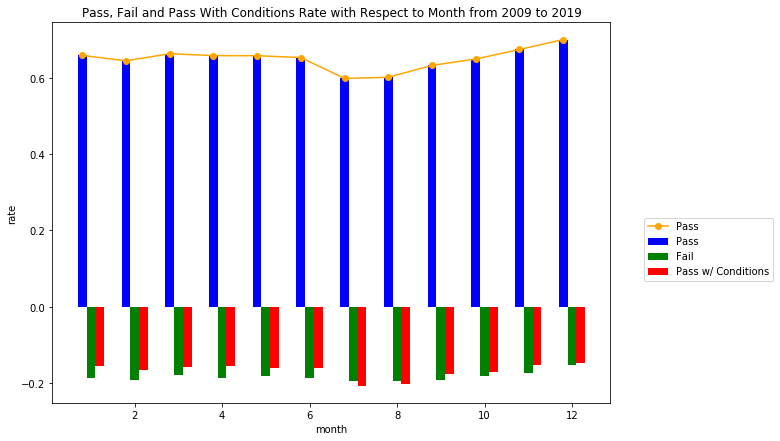

In [12]:
chicago['month'] = chicago['Inspection Date'].dt.month
rate_per_month = compute_avg_rate(chicago, 'month')
compute_plot(rate_per_month,'month','rate','Pass, Fail and Pass With Conditions Rate with Respect to Month from 2009 to 2019', False)

**Analysis**: The distribution of the rates over months is in general smooth. However, in the summer (July and August), the pass rate is apprarently lower than the other months and the pass with condition rate is slightly higher than the other months.

## 1.2. Is there a yearly pattern?

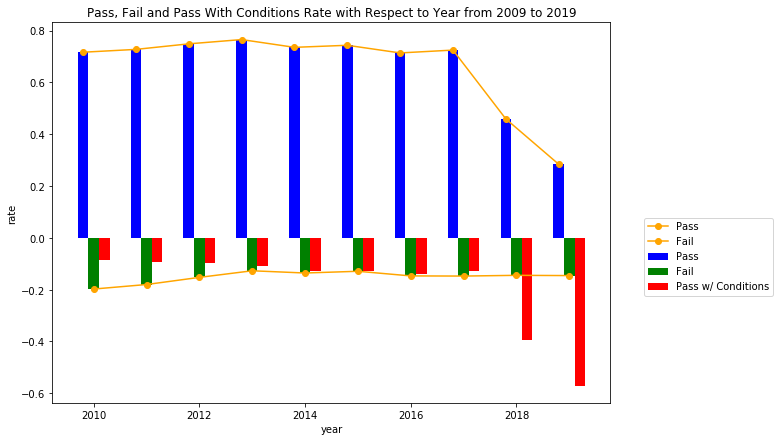

In [13]:
chicago['year'] = chicago['Inspection Date'].dt.year
rate_per_year = compute_avg_rate(chicago, 'year')
compute_plot(rate_per_year,'year','rate','Pass, Fail and Pass With Conditions Rate with Respect to Year from 2009 to 2019', True)

**Analysis**: According to Chicago Department of Public Health, the scheme used for inspection has a major change on July 1st, 2018. This is also reflected in the plot, from 2018 it sees a significant change of results. The pass rate has dropped significantly and the pass with condition rate has increased. This can be interpreted as a much stricter scheme which discovers more problems that can be solved during the inspection.
The fail rate slightly decreases with respect to year, indicating that the overall cleaniess situation of Chicago's food industry is improving.

# 2. Analysis by ZIP Code -- Is there a regional pattern for inspection results?
## 2.1. With result rate (pass, fail, pass with condtion) as the metric

In [47]:
def read_external_zip(file_path):
    """A helper function that reads in the zip codes used for plotting the map of Chicago
    Args:
        file_path (str): file path of the json file
    Returns:
        external_zip(list): list of zip codes used for plotting the map of Chicago
        geo_json_data(json): coordinates of each zip region in Chicago
    """
    state_geo_path = file_path
    geo_json_data = json.load(open(state_geo_path))

    external_zip = []
    for i in range(49):
        v = int(pd.read_json(state_geo_path)['features'].loc[i]['properties']['ZIP'])
        external_zip.append(v)
    
    return external_zip, geo_json_data

In [48]:
def compute_dataframe_for_map(chicago, data, external_zip):
    """A helper function that rearranges the data for plotting the map
    Args:
        chicago(dataframe): chicago food inspection dataset
        data(dataframe): dataframe requiring reordering of index
        external_zip(list): list of zip codes used for plotting the map
    Returns:
        map_data(dataframe): dataframe ready to be plotted in the map
    """
    my_dataframe = []
    myzip = chicago.Zip.unique().tolist()

    for zip in external_zip:
        if zip not in myzip:
            length = len(data.columns)
            row = [zip] + [0 for i in range(length)]
        else:
            row = [zip] + data.loc[zip].values.tolist()
        my_dataframe.append(row)

    map_data = pd.DataFrame(my_dataframe, columns = ['Zip'] + data.columns.tolist())
    map_data['Zip'] = map_data['Zip'].astype(str)
    return map_data

In [49]:
def plot_zip_map(path, chicago, feature):
    """A helper function that plots the map of chicago and helath score of each zip-based region
    Args:
        path(str): path of external json file
        chicago(dataframe): chicago food inspection dataset
        feature(str): which feature should the map plot show 
    Returns:
        chicago_map(map object): map plot
    """
    external_zip, chicago_geo_json_data = read_external_zip(path)
    data = chicago[chicago['License #'] > 0]
    data = data[data['Zip'].isin(external_zip)]

    zip_rate = compute_avg_rate(data,'Zip')
    
    chicago_coord = [41.881832, -87.623177]
    chicago_map = folium.Map(location=chicago_coord,tiles='cartodbpositron')
    zip_rate_data = compute_dataframe_for_map(chicago, zip_rate, external_zip)

    chicago_map.choropleth(geo_data=chicago_geo_json_data, data=zip_rate_data,
                 columns=['Zip', feature],
                 key_on='feature.properties.ZIP',
                 fill_color='BuPu', 
                 legend_name= feature + 'Rate')
    
    return chicago_map

**Plot the map by fail rate for each ZIP (in 10 years)**

In [50]:
plot_zip_map(ZIP_CODES_PATH, chicago, 'Fail')

**Plot the map by fail rate for each ZIP (old inspection scheme)**

In [51]:
plot_zip_map(ZIP_CODES_PATH, chicago_old, 'Fail')

**Plot the map by fail rate for each ZIP (new inspection scheme)**

In [52]:
plot_zip_map(ZIP_CODES_PATH, chicago_new, 'Fail')

**Analysis**

## 2.2. With health score as the metric

In [53]:
def compute_plot_zip_health_map(data, path):
    """A helper function that computes the health score for each zip-based region
    Args:
        data(dataframe): chicago food inspection dataset
        path(str): file path of the json file
    Returns:
        zip_health(dataframe): dataframe for health score w.r.t. zip code
        chicago_map(map object): map plot
    """
    external_zip, chicago_geo_json_data = read_external_zip(path)
    
    # Compute
    zip_health = data[data['Zip'].isin(external_zip)]\
            [['License #', 'health_score', 'Zip']].drop_duplicates()\
            .groupby('Zip').mean()['health_score'].to_frame()\
            .sort_values(by = 'health_score')
    
    range_len = np.max(zip_health['health_score']) - np.min(zip_health['health_score'])
    zip_health['health_score'] = 100*(zip_health['health_score'] - np.min(zip_health['health_score'])) / range_len
    
    # Plot
    chicago_coord = [41.881832, -87.623177]
    chicago_map = folium.Map(location=chicago_coord,tiles='cartodbpositron')
    
    health_score_data = compute_dataframe_for_map(data, zip_health, external_zip)

    chicago_map.choropleth(geo_data=chicago_geo_json_data, data=health_score_data,
                 columns=['Zip', 'health_score'],
                 key_on='feature.properties.ZIP',
                 fill_color='BuPu', 
                 legend_name='health_score Rate (%)')
    
    return zip_health, chicago_map

**Plot the map by health score for each ZIP (10 years)**

In [54]:
_, chicago_map_health = compute_plot_zip_health_map(chicago_health, ZIP_CODES_PATH)
chicago_map_health

**Plot the map by fail rate for each ZIP (old inspection scheme)**

In [55]:
_, chicago_map_health_before = compute_plot_zip_health_map(chicago_health_before, ZIP_CODES_PATH)
chicago_map_health_before

**Plot the map by fail rate for each ZIP (new inspection scheme)**

In [56]:
_, chicago_map_health_after = compute_plot_zip_health_map(chicago_health_after, ZIP_CODES_PATH)
chicago_map_health_after

**Analysis**

# 3. Analysis by risk level
## 3.1. Is there a pattern for risk level with inspection results?

In [24]:
def compute_plot_by_risk(data, removeAll):
    """A helper function that plot the Pass, Fail and Pass With Conditions rate for each risk level
    Args:
        data(dataframe): chicago food inspection dataset
        removeAll(boolean): flag to show if remove risk level "All" 
    Returns:
        risk_rate(dataframe): dataframe of risk level with Pass, Fail and Pass With Conditions rate
    """
    risk_rate = compute_avg_rate(data, 'Risk') 
    
    if removeAll == True:
        risk_rate.loc[risk_rate.index[1:]]\
        .plot(kind = 'bar', figsize = (10, 10))\
            .legend(bbox_to_anchor=(1.2, 0.5))
        
        risk_rate = risk_rate.loc[risk_rate.index[1:]]
    else:
        risk_rate.plot(kind = 'bar', figsize = (10, 10))\
            .legend(bbox_to_anchor=(1.2, 0.5))
    
    return risk_rate

**Plot different risk level  (old inspection scheme)**

Results,Fail,Pass,Pass w/ Conditions
Risk,,,
Risk 1 (High),0.200331,0.704679,0.094989
Risk 2 (Medium),0.216237,0.686063,0.097700
Risk 3 (Low),0.250531,0.720624,0.028845


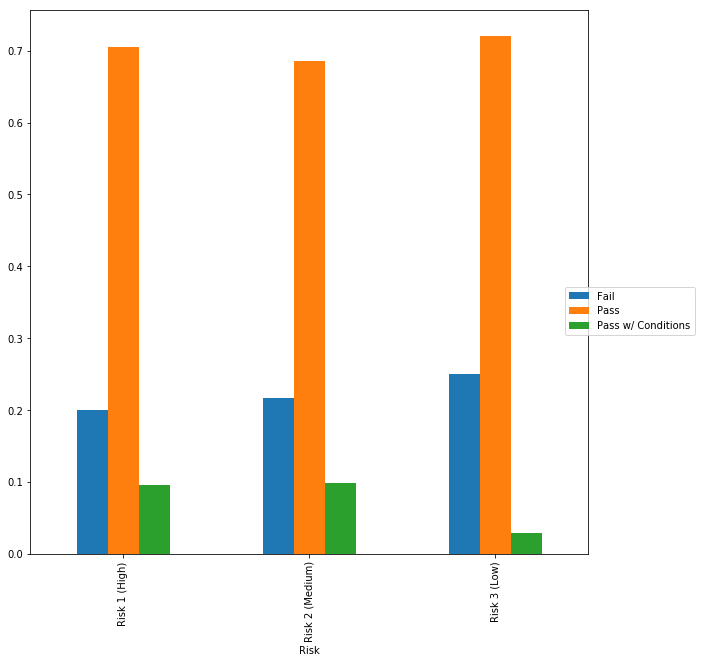

In [57]:
compute_plot_by_risk(chicago_old, True)

**Plot different risk level (new inspection scheme)**

Results,Fail,Pass,Pass w/ Conditions
Risk,,,
Risk 1 (High),0.143463,0.224351,0.632187
Risk 2 (Medium),0.146729,0.249713,0.603558
Risk 3 (Low),0.182508,0.296095,0.521397


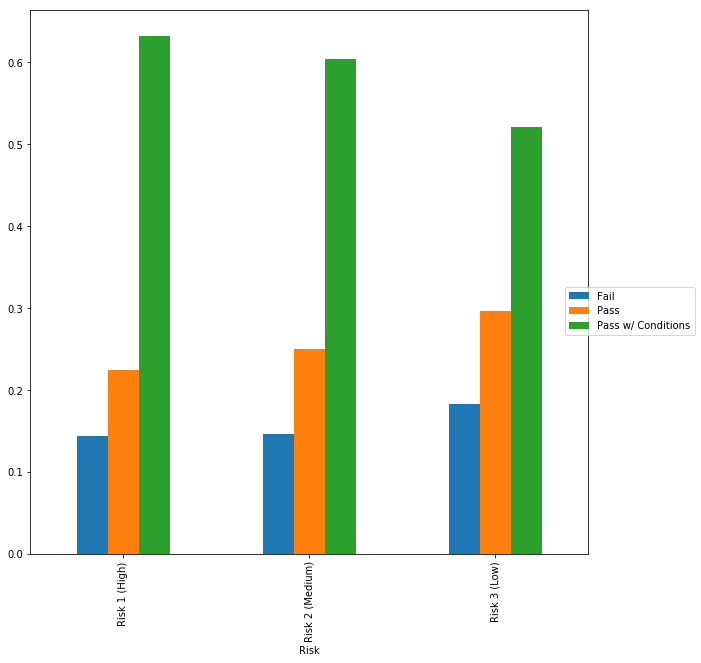

In [58]:
compute_plot_by_risk(chicago_new, False)

**Plot different risk level (within 10 years)**

Results,Fail,Pass,Pass w/ Conditions
Risk,,,
Risk 1 (High),0.200926,0.634423,0.164651
Risk 2 (Medium),0.214943,0.633161,0.151897
Risk 3 (Low),0.244228,0.670865,0.084907


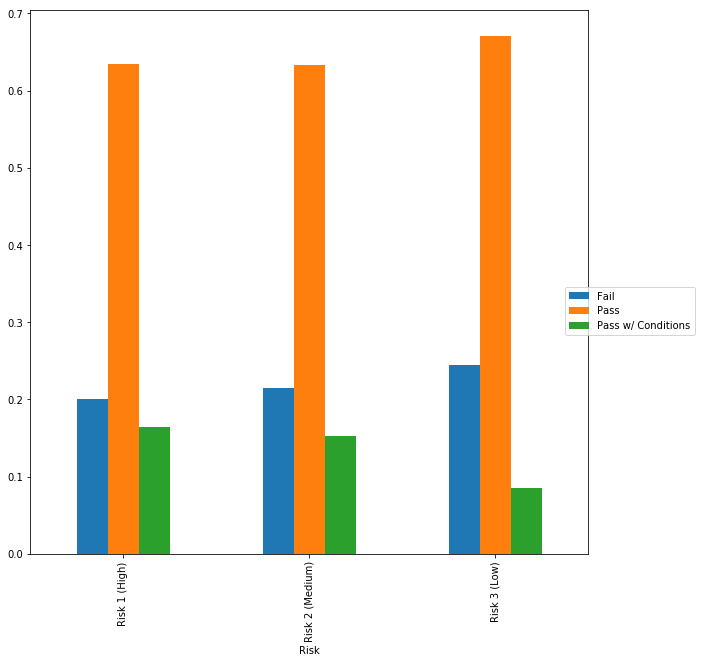

In [59]:
compute_plot_by_risk(chicago, True)

**Analysis**

## 3.1. Is there a pattern for risk level with health score?

In [60]:
def compute_risk_health(data):
    """A helper function that computes the health score for each risk level
    Args:
        data(dataframe): chicago food inspection dataset
    Returns:
        data(dataframe): health score for each risk level
    """
    data = data[['License #', 'health_score', 'Risk']].drop_duplicates()\
            .groupby('Risk').mean()['health_score'].to_frame()\
            .sort_values(by = 'health_score')
    return data

**Risk level with health score (old inspection scheme)**

In [64]:
compute_risk_health(chicago_health_before).drop(['All'])

,health_score
Risk,
Risk 1 (High),63.388080
Risk 2 (Medium),75.316558
Risk 3 (Low),92.996028


**Risk level with health score (After inspection scheme)**

In [65]:
compute_risk_health(chicago_health_after).drop(['All'])

,health_score
Risk,
Risk 1 (High),83.675164
Risk 2 (Medium),88.722171
Risk 3 (Low),94.541331


**Risk level with health score (within 10 years)**

In [66]:
compute_risk_health(chicago_health).drop(['All'])

,health_score
Risk,
Risk 1 (High),58.407642
Risk 2 (Medium),73.889161
Risk 3 (Low),92.881331


# 4. Analysis by different facility type
## 4.1. What is the ranking of facility types according inspection results?

In [221]:
def compute_plot_facilityType_rate(dataframe, topK, sortBy):
    """A helper function that computes the average pass, pass with condition and fail rate for each facility type and plot it. 
    Args:
        data(dataframe): chicago food inspection dataset
        topK(int): top number of facility type
        sortBy(str): sort by what feature
    """
    myfacilities = dataframe['Facility Type'].value_counts().index.tolist()[:topK]
    data = dataframe[dataframe['Facility Type'].isin(myfacilities)]
    Facility_Type_rate = compute_avg_rate(data,'Facility Type')
    Facility_Type_rate.sort_values(by = sortBy)\
        .plot(kind = 'bar', figsize = (10, 10))\
        .legend(bbox_to_anchor=(1.2, 0.5))

**Facility types with result rate (within 10 years)**

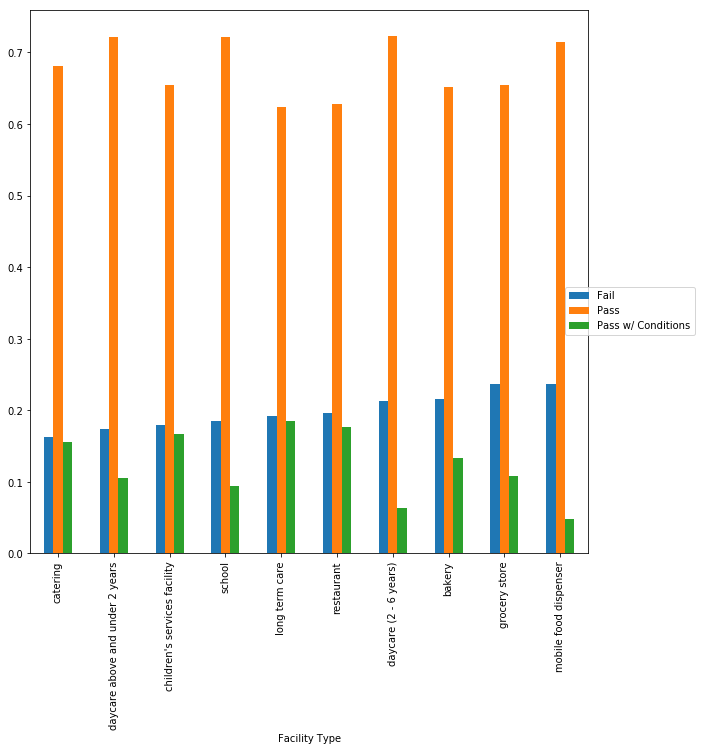

In [222]:
# 10 years
compute_plot_facilityType_rate(chicago,10, 'Fail')

**Facility types with result rate (within 10 years)**

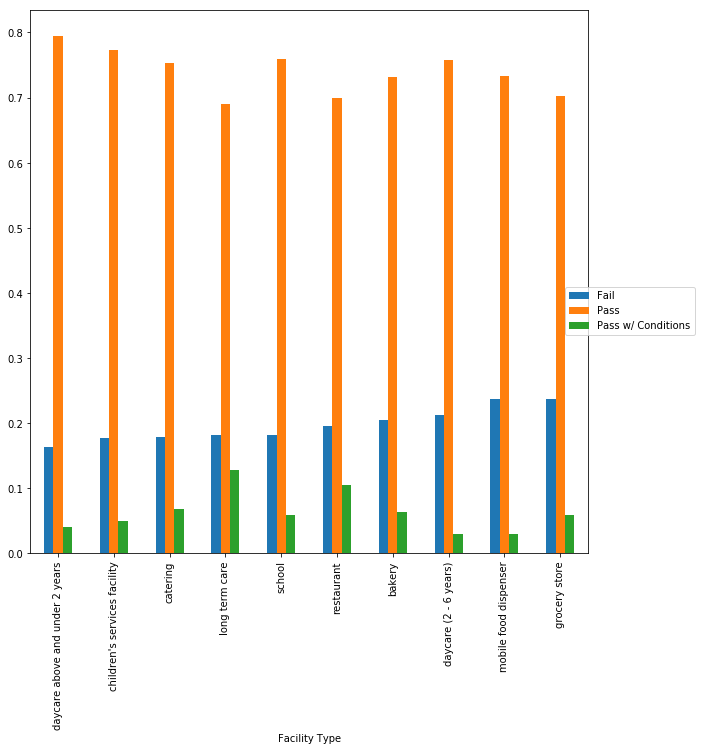

In [223]:
# Before 2018
compute_plot_facilityType_rate(chicago_old,10, 'Fail')

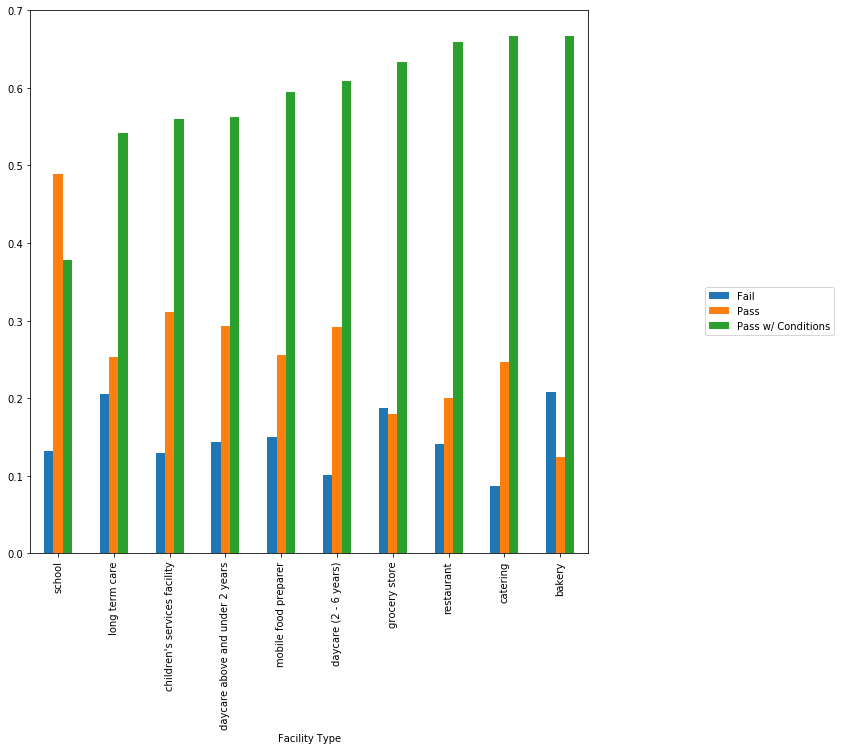

In [224]:
# After 2018

compute_plot_facilityType_rate(chicago_new,10, 'Pass w/ Conditions')

## 4.2. What is the ranking of facility types according health score?

In [52]:
def compute_facilityType_healthScore(dataframe,topK):
    """A helper function that computes the health score for different facility type
    Args:
        data(dataframe): chicago food inspection dataset
        topK(int): top number of facility type
    Returns:
        facility_health_score(dataframe): health score for topK facility type
    """
    myfacilities = dataframe['Facility Type'].value_counts().index.tolist()[:topK]
    facility_health_score = dataframe[(dataframe['Facility Type'].isin(myfacilities)) & (dataframe['License #'] > 0)]\
            [['License #', 'health_score', 'Facility Type']].drop_duplicates()\
            .groupby('Facility Type').mean()['health_score'].to_frame()\
            .sort_values(by = 'health_score', ascending = False)
    
    return facility_health_score
    

In [54]:
# Before 2018

compute_facilityType_healthScore(chicago_health_before,10)

,health_score
Facility Type,
mobile food dispenser,96.086323
daycare (2 - 6 years),83.289340
children's services facility,81.731579
daycare above and under 2 years,81.609504
grocery store,74.859450
catering,74.650510
long term care,70.581028
bakery,64.383592
restaurant,61.376254


In [55]:
# After 2018
compute_facilityType_healthScore(chicago_health_after,10)

,health_score
Facility Type,
school,91.825434
daycare (2 - 6 years),88.935065
mobile food preparer,88.571429
children's services facility,87.705808
catering,86.953125
daycare above and under 2 years,86.318841
grocery store,82.614139
restaurant,80.360607
bakery,78.825758


In [53]:
# Total
compute_facilityType_healthScore(chicago_health,10)

,health_score
Facility Type,
navy pier kiosk,97.833333
special event,88.371795
grocery store,72.777132
shelter,68.590909
long term care,60.624031
restaurant,56.382825
school,41.530151
church kitchen,36.500000
